# Munich R Courses - Deep learning showcase

Content:
1. working with image data in R (downloading data, plotting, preprocessing)
2. creating deep learning architectures using the keras interface
    1. Starting with Fashion MNIST
    3. Evaluation of model output
    4. Storage and loading of models
    2. Sequential and Functional API
3. running and comparing different architectures (FCN, CNN)
5. Regularization and its effects on the generalization performance
6. From bw to rgb images
7. Transfer learning with pretrained models in case of few labeled data


## 1. Working with image data in R

### Data provided by the keras package - MNIST

MNIST is a [famous dataset provided by Yann LeCun et al.](http://yann.lecun.com/exdb/mnist/) that consists of 70K 28x28 grayscale images of handwritten digits.

In [70]:
# install and load the package
# install.packages('keras')
library('keras')

In [71]:
# files will be stored at
# ~/.keras/datasets
mnist = dataset_mnist()
# what does the object contain?
str(mnist)
# 60K train and 10K test data with input X and labels y

List of 2
 $ train:List of 2
  ..$ x: int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000(1d)] 5 0 4 1 9 2 1 3 1 4 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000(1d)] 7 2 1 0 4 1 4 9 5 9 ...


In [72]:
# assign values 
x_train = mnist$train$x
x_test = mnist$test$x
y_train = mnist$train$y
y_test = mnist$test$y

In [73]:
# classes for train and test are equally balanced 
# (-> what if they were not?)
table(y_test)
table(y_train)

y_test
   0    1    2    3    4    5    6    7    8    9 
 980 1135 1032 1010  982  892  958 1028  974 1009 

y_train
   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

In [74]:
# x_train is an array that contains 60K images with channel size 1 and dimensions 28x28 (as they are black-white)
# resulting in tensor of shape [amount images, xdim, ydim]
# If the images were coloured, they would contain  3 channels (RGB) resulting in shape
# [60000, 28, 28, 3]

# inspect one train image
idx = 87
foo_img = x_train[idx, , ]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))

class: matrix
max value: 254
min value: 0
mean value: 27.8469387755102
data type: integer

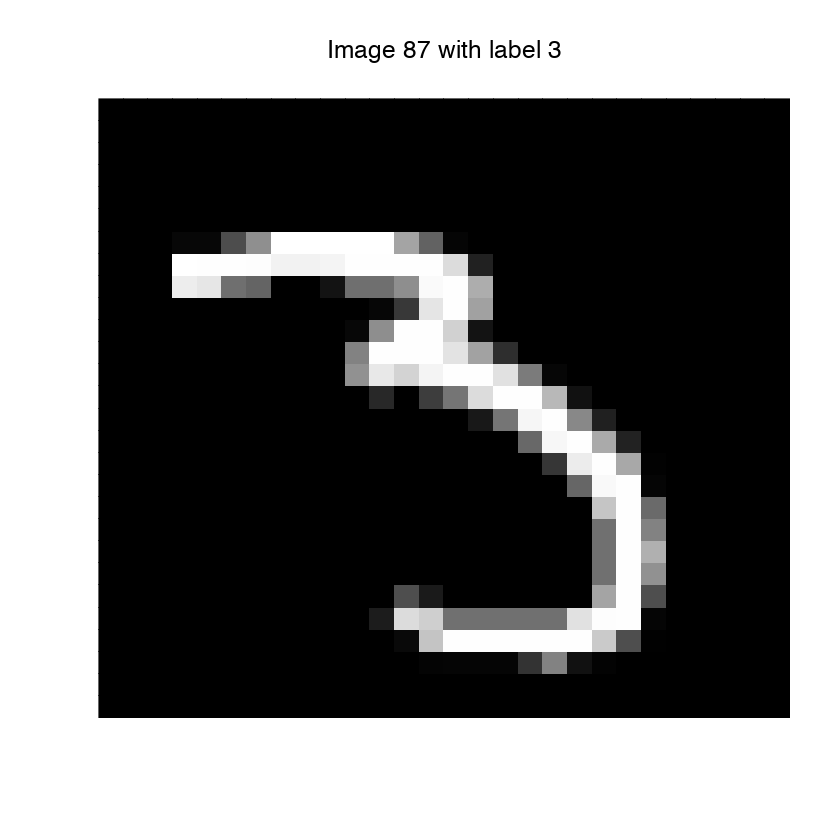

In [75]:
# helper to rotate the image
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(foo_img), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Image ', idx, ' with label ', foo_label))

### Data provided by the keras package - Fashion MNIST

Fashion Mnist is mainly a more complicated version of MNIST with 10 classes of different fashion objects. The dataset is published by [Zalando Research](https://github.com/zalandoresearch/fashion-mnist) and also often used for deep learning benchmarks. The dataset as well consists of 70K 28x28 grayscale images of fashion objects in 10 balanced categories such as bags, shoes, trousers, ...

In [76]:
# files will be stored at
# ~/.keras/datasets
fmnist = dataset_fashion_mnist()
# what does the object contain?
str(fmnist)
# 60K train and 10K test data with input X and labels y
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y

List of 2
 $ train:List of 2
  ..$ x: int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000(1d)] 9 0 0 3 0 2 7 2 5 5 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000(1d)] 9 2 1 1 6 1 4 6 5 7 ...


class: matrix
max value: 255
min value: 0
mean value: 107.353316326531
data type: integer

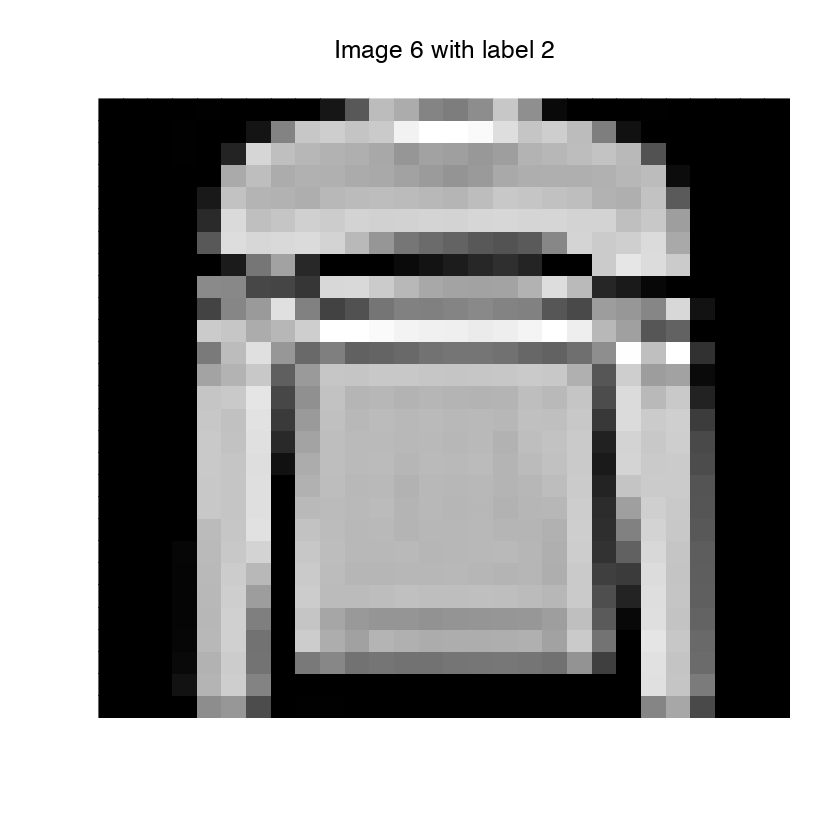

In [77]:
# inspect one train image
idx = 6
foo_img = x_train[idx, , ]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))
# helper to rotate the image
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(foo_img), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Image ', idx, ' with label ', foo_label))

### Data provided by the keras package - CIFAR 10

Cifar10 is a [public dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html) that contains 60K 32x32 RGB images from 10 classes (airplanes, deer, cars, cats, ...) and is widely used for benchmarking DL algorithms in image classification. 

In [78]:
# can take up to 5 min as the dataset contains roughly 170MB
# also stored at ~/.keras/datasets
cifar = dataset_cifar10()

In [79]:
# similar structure as MNIST
# but now with channel depth 3
str(cifar)
x_train = cifar$train$x
y_train = cifar$train$y
x_test = cifar$test$x
y_test = cifar$test$y

List of 2
 $ train:List of 2
  ..$ x: int [1:50000, 1:32, 1:32, 1:3] 59 154 255 28 170 159 164 28 134 125 ...
  ..$ y: int [1:50000, 1] 6 9 9 4 1 1 2 7 8 3 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:32, 1:32, 1:3] 158 235 158 155 65 179 160 83 23 217 ...
  ..$ y: num [1:10000, 1] 3 8 8 0 6 6 1 6 3 1 ...


class: array
max value: 247
min value: 0
mean value: 111.307291666667
data type: integer
label of image 177 is 1

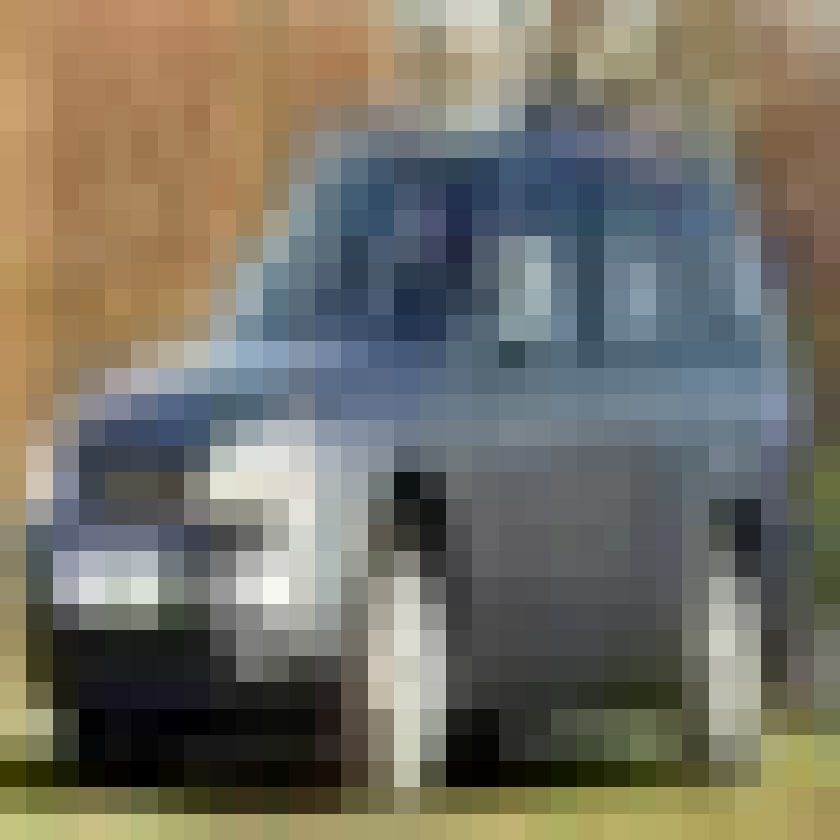

In [80]:
# inspect one train image
# consists of 3 matrices of RGB integers in {0, ..., 255}
idx = 177
foo_img = x_train[idx, , ,]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))

# print the label 
cat(paste0('\nlabel of image ', idx, ' is ', foo_label))

# plot the images with grid package
# therefore, pixels have to be squashed to [0, 1]
library(grid)
r = foo_img[ , , 1] / 255
g = foo_img[ , , 2] / 255
b = foo_img[ , , 3] / 255
col <- rgb(r, g, b)
dim(col) <- dim(r)
grid.raster(col, interpolate=FALSE, name = "yo")

### Data provided by the keras package - imdb 

Besides image data, the package also provides dummy datasets for text mining. This dataset contains 25K movie reviews and their correpsonding sentiment (positive/ negative). The dataset was already heavily preprocessed: words were encoded in a dictionary of integers for data storage reasons and can be re-coded this way. Also, they were sorted according to their occurence frequency in the text. The dataset can be used for sentiment analysis on text data.



In [81]:
# TODO: whole chapter, does this even make sense?
imdb = dataset_imdb()
imdb_dict = dataset_imdb_word_index()

In [82]:
str(imdb)

List of 2
 $ train:List of 2
  ..$ x:List of 25000
  .. ..$ : int [1:218] 1 14 22 16 43 530 973 1622 1385 65 ...
  .. ..$ : int [1:189] 1 194 1153 194 8255 78 228 5 6 1463 ...
  .. ..$ : int [1:141] 1 14 47 8 30 31 7 4 249 108 ...
  .. ..$ : int [1:550] 1 4 18609 16085 33 2804 4 2040 432 111 ...
  .. ..$ : int [1:147] 1 249 1323 7 61 113 10 10 13 1637 ...
  .. ..$ : int [1:43] 1 778 128 74 12 630 163 15 4 1766 ...
  .. ..$ : int [1:123] 1 6740 365 1234 5 1156 354 11 14 5327 ...
  .. ..$ : int [1:562] 1 4 14906 716 4 65 7 4 689 4367 ...
  .. ..$ : int [1:233] 1 43 188 46 5 566 264 51 6 530 ...
  .. ..$ : int [1:130] 1 14 20 47 111 439 3445 19 12 15 ...
  .. ..$ : int [1:450] 1 785 189 438 47 110 142 7 6 7475 ...
  .. ..$ : int [1:99] 1 54 13 1610 14 20 13 69 55 364 ...
  .. ..$ : int [1:117] 1 13 119 954 189 1554 13 92 459 48 ...
  .. ..$ : int [1:238] 1 259 37 100 169 1653 1107 11 14 418 ...
  .. ..$ : int [1:109] 1 503 20 33 118 481 302 26 184 52 ...
  .. ..$ : int [1:129] 1 6 964 437

In [83]:
# assign the data
x_train = imdb$train$x
y_train = imdb$train$y
x_test = imdb$test$x
y_test = imdb$test$y

In [84]:
# look at the class frequencies
table(y_train)

y_train
    0     1 
12500 12500 

In [85]:
# exemplary review
foo_text = x_train[1][[1]]
foo_text

[1]     1    14    22    16    43   530   973  1622  1385    65   458  4468
 [13]    66  3941     4   173    36   256     5    25   100    43   838   112
 [25]    50   670 22665     9    35   480   284     5   150     4   172   112
 [37]   167 21631   336   385    39     4   172  4536  1111    17   546    38
 [49]    13   447     4   192    50    16     6   147  2025    19    14    22
 [61]     4  1920  4613   469     4    22    71    87    12    16    43   530
 [73]    38    76    15    13  1247     4    22    17   515    17    12    16
 [85]   626    18 19193     5    62   386    12     8   316     8   106     5
 [97]     4  2223  5244    16   480    66  3785    33     4   130    12    16
[109]    38   619     5    25   124    51    36   135    48    25  1415    33
[121]     6    22    12   215    28    77    52     5    14   407    16    82
[133] 10311     8     4   107   117  5952    15   256     4 31050     7  3766
[145]     5   723    36    71    43   530   476    26   400   317    46     7
[157]     4 12118  1029    13   104    88     4   381    15   297    98    32
[169]  2071    56    26   141     6   194  7486    18     4   226    22    21
[181]   134   476    26   480     5   144    30  5535    18    51    36    28
[193]   224    92    25   104     4   226    65    16    38  1334    88    12
[205]    16   283     5    16  4472   113   103    32    15    16  5345    19
[217]   178    32

In [86]:
# decode and use helper function therefore
get_word = function(idx, dict){
    return(names(which(dict == as.integer(idx))))
}
decoded = lapply(foo_text, function(x)(get_word(idx = x, dict = imdb_dict)))
decoded

[[1]]
[1] "the"

[[2]]
[1] "as"

[[3]]
[1] "you"

[[4]]
[1] "with"

[[5]]
[1] "out"

[[6]]
[1] "themselves"

[[7]]
[1] "powerful"

[[8]]
[1] "lets"

[[9]]
[1] "loves"

[[10]]
[1] "their"

[[11]]
[1] "becomes"

[[12]]
[1] "reaching"

[[13]]
[1] "had"

[[14]]
[1] "journalist"

[[15]]
[1] "of"

[[16]]
[1] "lot"

[[17]]
[1] "from"

[[18]]
[1] "anyone"

[[19]]
[1] "to"

[[20]]
[1] "have"

[[21]]
[1] "after"

[[22]]
[1] "out"

[[23]]
[1] "atmosphere"

[[24]]
[1] "never"

[[25]]
[1] "more"

[[26]]
[1] "room"

[[27]]
[1] "titillate"

[[28]]
[1] "it"

[[29]]
[1] "so"

[[30]]
[1] "heart"

[[31]]
[1] "shows"

[[32]]
[1] "to"

[[33]]
[1] "years"

[[34]]
[1] "of"

[[35]]
[1] "every"

[[36]]
[1] "never"

[[37]]
[1] "going"

[[38]]
[1] "villaronga"

[[39]]
[1] "help"

[[40]]
[1] "moments"

[[41]]
[1] "or"

[[42]]
[1] "of"

[[43]]
[1] "every"

[[44]]
[1] "chest"

[[45]]
[1] "visual"

[[46]]
[1] "movie"

[[47]]
[1] "except"

[[48]]
[1] "her"

[[49]]
[1] "was"

[[50]]
[1] "several"

[[51]]
[1] "of"

[[52]]
[1] "enough"

[[53]]
[1] "more"

[[54]]
[1] "with"

[[55]]
[1] "is"

[[56]]
[1] "now"

[[57]]
[1] "current"

[[58]]
[1] "film"

[[59]]
[1] "as"

[[60]]
[1] "you"

[[61]]
[1] "of"

[[62]]
[1] "mine"

[[63]]
[1] "potentially"

[[64]]
[1] "unfortunately"

[[65]]
[1] "of"

[[66]]
[1] "you"

[[67]]
[1] "than"

[[68]]
[1] "him"

[[69]]
[1] "that"

[[70]]
[1] "with"

[[71]]
[1] "out"

[[72]]
[1] "themselves"

[[73]]
[1] "her"

[[74]]
[1] "get"

[[75]]
[1] "for"

[[76]]
[1] "was"

[[77]]
[1] "camp"

[[78]]
[1] "of"

[[79]]
[1] "you"

[[80]]
[1] "movie"

[[81]]
[1] "sometimes"

[[82]]
[1] "movie"

[[83]]
[1] "that"

[[84]]
[1] "with"

[[85]]
[1] "scary"

[[86]]
[1] "but"

[[87]]
[1] "pratfalls"

[[88]]
[1] "to"

[[89]]
[1] "story"

[[90]]
[1] "wonderful"

[[91]]
[1] "that"

[[92]]
[1] "in"

[[93]]
[1] "seeing"

[[94]]
[1] "in"

[[95]]
[1] "character"

[[96]]
[1] "to"

[[97]]
[1] "of"

[[98]]
[1] "70s"

[[99]]
[1] "musicians"

[[100]]
[1] "with"

[[101]]
[1] "heart"

[[102]]
[1] "had"

[[103]]
[1] "shadows"

[[104]]
[1] "they"

[[105]]
[1] "of"

[[106]]
[1] "here"

[[107]]
[1] "that"

[[108]]
[1] "with"

[[109]]
[1] "her"

[[110]]
[1] "serious"

[[111]]
[1] "to"

[[112]]
[1] "have"

[[113]]
[1] "does"

[[114]]
[1] "when"

[[115]]
[1] "from"

[[116]]
[1] "why"

[[117]]
[1] "what"

[[118]]
[1] "have"

[[119]]
[1] "critics"

[[120]]
[1] "they"

[[121]]
[1] "is"

[[122]]
[1] "you"

[[123]]
[1] "that"

[[124]]
[1] "isn't"

[[125]]
[1] "one"

[[126]]
[1] "will"

[[127]]
[1] "very"

[[128]]
[1] "to"

[[129]]
[1] "as"

[[130]]
[1] "itself"

[[131]]
[1] "with"

[[132]]
[1] "other"

[[133]]
[1] "tricky"

[[134]]
[1] "in"

[[135]]
[1] "of"

[[136]]
[1] "seen"

[[137]]
[1] "over"

[[138]]
[1] "landed"

[[139]]
[1] "for"

[[140]]
[1] "anyone"

[[141]]
[1] "of"

[[142]]
[1] "gilmore's"

[[143]]
[1] "br"

[[144]]
[1] "show's"

[[145]]
[1] "to"

[[146]]
[1] "whether"

[[147]]
[1] "from"

[[148]]
[1] "than"

[[149]]
[1] "out"

[[150]]
[1] "themselves"

[[151]]
[1] "history"

[[152]]
[1] "he"

[[153]]
[1] "name"

[[154]]
[1] "half"

[[155]]
[1] "some"

[[156]]
[1] "br"

[[157]]
[1] "of"

[[158]]
[1] "'n"

[[159]]
[1] "odd"

[[160]]
[1] "was"

[[161]]
[1] "two"

[[162]]
[1] "most"

[[163]]
[1] "of"

[[164]]
[1] "mean"

[[165]]
[1] "for"

[[166]]
[1] "1"

[[167]]
[1] "any"

[[168]]
[1] "an"

[[169]]
[1] "boat"

[[170]]
[1] "she"

[[171]]
[1] "he"

[[172]]
[1] "should"

[[173]]
[1] "is"

[[174]]
[1] "thought"

[[175]]
[1] "frog"

[[176]]
[1] "but"

[[177]]
[1] "of"

[[178]]
[1] "script"

[[179]]
[1] "you"

[[180]]
[1] "not"

[[181]]
[1] "while"

[[182]]
[1] "history"

[[183]]
[1] "he"

[[184]]
[1] "heart"

[[185]]
[1] "to"

[[186]]
[1] "real"

[[187]]
[1] "at"

[[188]]
[1] "barrel"

[[189]]
[1] "but"

[[190]]
[1] "when"

[[191]]
[1] "from"

[[192]]
[1] "one"

[[193]]
[1] "bit"

[[194]]
[1] "then"

[[195]]
[1] "have"

[[196]]
[1] "two"

[[197]]
[1] "of"

[[198]]
[1] "script"

[[199]]
[1] "their"

[[200]]
[1] "with"

[[201]]
[1] "her"

[[202]]
[1] "nobody"

[[203]]
[1] "most

## Load and manipulate your own image data

We transform one example image in the R-eadable data format. [Random Forest creator Leo Breiman](https://de.wikipedia.org/wiki/Leo_Breiman) serves as an example here. The R package [magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html#installing_magick) offers very comprehensive image manipulation methods in a unified framework.

In [87]:
# install.packages('magick')
library('magick')
# read the image
data_path = './data/Breiman.jpg'
img = image_read(path = data_path)


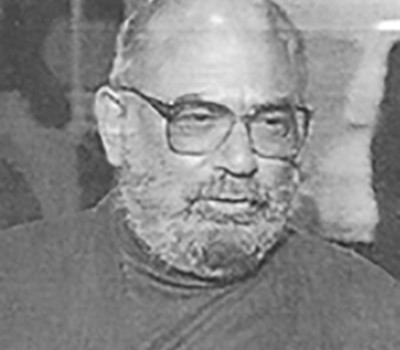

  format width height colorspace matte filesize density
1   JPEG   400    350       Gray FALSE    23266   72x72

In [88]:
# plot the image
img

In [89]:
# get data from the image object
img_data = image_data(img)
str(img_data)

 'bitmap' raw [1, 1:400, 1:350] 5b 59 57 55 ...


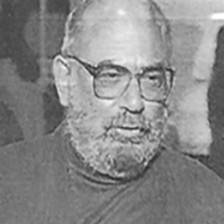

  format width height colorspace matte filesize density
1   JPEG   224    224       Gray FALSE        0   72x72

In [90]:
# resize the image in case they have different formats
# e.g. Resnet takes 224x224 images as input
resized_img = magick::image_resize(image = img, geometry = "224x224!")
resized_img

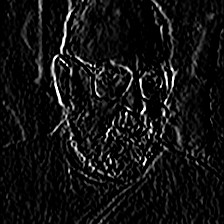

  format width height colorspace matte filesize density
1   JPEG   224    224       Gray FALSE        0   72x72

In [91]:
# Convolve over the image with a Sobel filter to detect edges (as is done in the lecture slides)
# therefore, the pipe operator is used which works the same was as in unix
sobel_img = resized_img %>%
    image_convolve('Sobel')
sobel_img

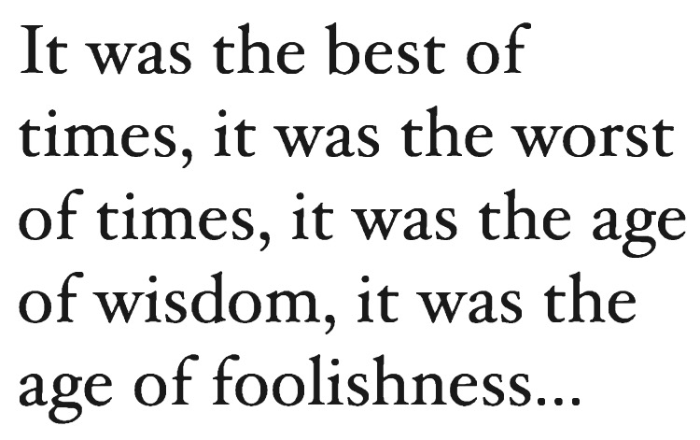

  format width height colorspace matte filesize density
1    PNG   700    440       sRGB FALSE   109894   72x72

In [92]:
# last perk: automated Optical Character Recognition on images of text 
# requires package
# install.packages("tesseract")
library('tesseract')
text_img = image_read('http://d2jaiao3zdxbzm.cloudfront.net/wp-content/uploads/figure-65.png')
text_img

In [93]:
text = image_ocr(text_img)
cat(text)

It was the best of
times, it was the worst
of times, it was the age
of wisdom, it was the
age of foolishness...



## 2. Getting started with Keras for modeling

Running and training neural networks with keras mainly consists of the following steps:
1. Reading and splitting data
2. Defininig the architecture of the model
3. Training the model and setting the hyperparameters for this
4. Evaluation of the model performance

In the following, we will train different model architectures on the task to classifiy the Fashion Mnist images in their corresponding 10 categories. Also, Keras allows the specification of the model architecture in a *sequential* and a *functional* way, both of which will be used in the following. 


### Reading and preparing the data

In [94]:
# read the data
fmnist = dataset_fashion_mnist()
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y
# dictionary for translation of the labels to meaningful category names
label_dict = cbind(c('tshirt', 'trouser', 'pullover', 'dress', 'coat', 
                     'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot'), 
                   c(0:9))

In [95]:
# convert the labels to categorical one-hot-encoded vectors
# store the real value as well and translate them into meaningful classes
y_train_noncateg = cbind(y_train, label_dict[match(y_train, label_dict[, 2]), 1])
y_test_noncateg = cbind(y_test, label_dict[match(y_test, label_dict[, 2]), 1])
y_train = to_categorical(y = y_train)
y_test = to_categorical(y = y_test)

# flatten the data input arrays from 60K 28x28 matrix to 60K 784 vector format
x_train = array_reshape(x_train, c(nrow(x_train), 28*28))
x_test = array_reshape(x_test, c(nrow(x_test), 28*28))

## Defining the architecture - Sequential

For a first run, we want to use a Multi-Layer-Preceptron (MLP), which consists of three inner hidden layers with varying size (128, 64, 32) 


In [96]:
# define and instantiate the sequential model type
model = keras_model_sequential() 

# build the model sequentially layer-wise with the pipe operator %>%
model %>% 
    # input the data as vectors of length 28x28 = 784
    # define the three hidden layers with relu activation and (128, 64, 32) neurons per layer
    layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%

    # add softmax as activation for the last layer as we want to output probality 
    # scores in [0, 1] for the 10 classes
    layer_dense(units = 10, activation = 'softmax')


In [97]:
# summary() allows us to check the architecture
# for instance, the 3rd layer contains 2080 = 64*32 + 32 weight parameters, as 32 neurons are connected
# with the output from the preceeding 64 neurons and are each summed with a bias 
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_41 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
dense_42 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dense_43 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_44 (Dense)                    (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


### Compiling and running the model 

In [98]:
# again, use the pipe operator %>%
# choose categorical XE as the classifier loss and 
# optimize the weights sequentially with rmsprop 
# check the CRAN documentation for more information on choosable losses, optimizer and metrics
# this step defines the computational graph that is getting executed in the next step
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [99]:
# train the compiled model with the fit function
# save the training progress in the history file
history = model %>% fit(
    x_train, y_train, 
    epochs = 5, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

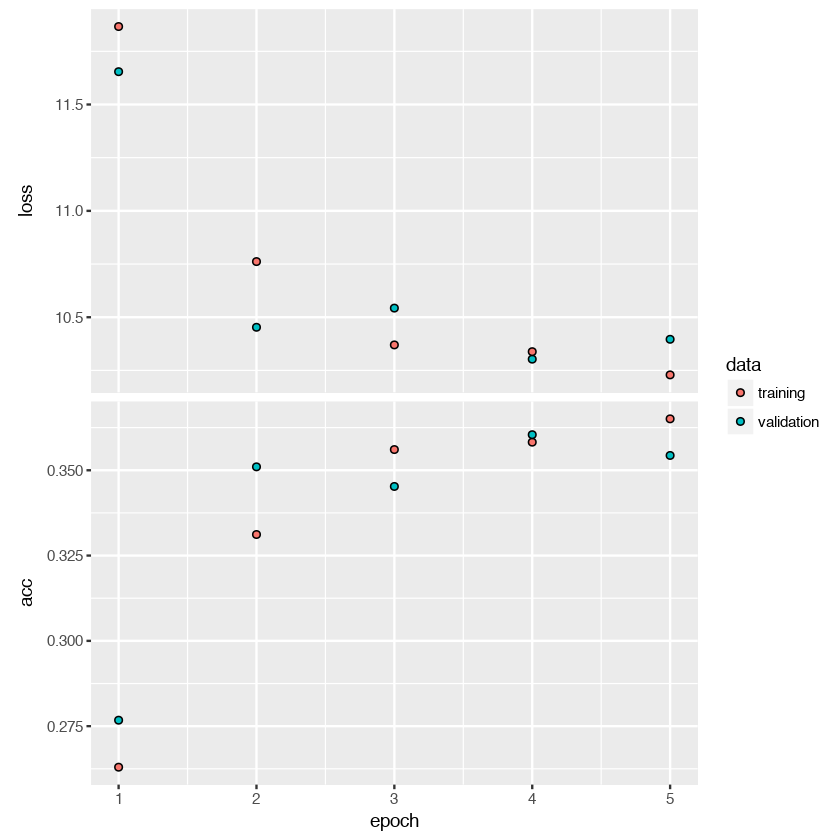

In [100]:
plot(history)

### Making predictions

In [101]:
# get the test performance of the trained model
test_perf = model %>% evaluate(x_test, y_test)
test_perf

$loss
[1] 10.35434

$acc
[1] 0.3566

In [102]:
# make hard predictions on all our test data
preds = model %>% predict_classes(x_test)
pred_frame = as.data.frame(cbind(preds, label_dict[match(preds, label_dict[, 2]), 1], y_test_noncateg))
pred_frame[, 1] = factor(pred_frame[, 1], levels = as.character(c(0:9)))
colnames(pred_frame) = c('yhat', 'yhat_label', 'y', 'y_label')
head(pred_frame)

yhat,yhat_label,y,y_label
5,sandal,9,ankleboot
6,shirt,2,pullover
3,dress,1,trouser
3,dress,1,trouser
6,shirt,6,shirt
3,dress,1,trouser


In [103]:
# make soft predictions (softmax) on all our test data
preds = model %>% predict_proba(x_test)
soft_pred_frame = cbind(preds, y_test_noncateg)
colnames(soft_pred_frame) = c(paste0('yhat_class_', c(0:9)), 'y', 'y_label')
head(soft_pred_frame)

yhat_class_0,yhat_class_1,yhat_class_2,yhat_class_3,yhat_class_4,yhat_class_5,yhat_class_6,yhat_class_7,yhat_class_8,yhat_class_9,y,y_label
0,0,0,0,0,1,0,0,0,0,9,ankleboot
0,0,0,0,0,0,1,0,0,0,2,pullover
0,0,0,1,0,0,0,0,0,0,1,trouser
0,0,0,1,0,0,0,0,0,0,1,trouser
0,0,0,0,0,0,1,0,0,0,6,shirt
0,0,0,1,0,0,0,0,0,0,1,trouser


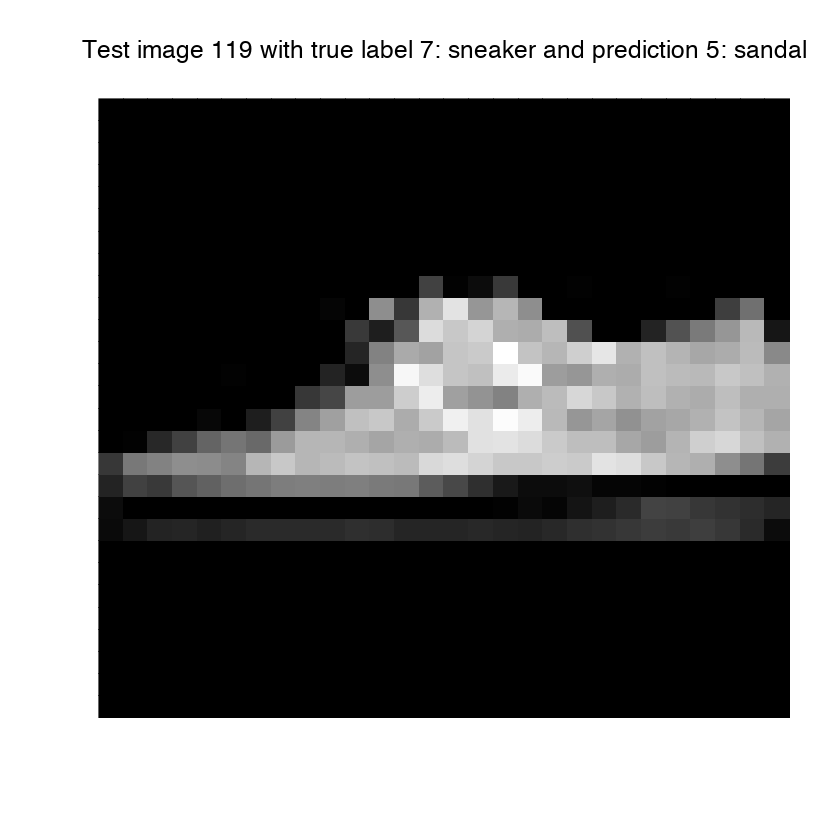

In [104]:
# check predictions for one test image
idx = 119
img_test = array_reshape(x_test[idx, ], c(28, 28))
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(img_test), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Test image ', idx,  
                ' with true label ', 
                y_test_noncateg[idx, 1], 
                ': ', 
                y_test_noncateg[idx, 2], 
                ' and prediction ', 
                pred_frame[idx, 1], ': ', 
                pred_frame[idx, 2]))

In [105]:
# check the confusion matrix
# install.packages('caret')
library('caret')
conf = confusionMatrix(data = pred_frame[, 1], reference = pred_frame[, 3])
conf_matrix = conf$table
colnames(conf_matrix) = label_dict[, 1]
rownames(conf_matrix) = label_dict[, 1]
conf_matrix

           Reference
Prediction  tshirt trouser pullover dress coat sandal shirt sneaker bag
  tshirt         9       0        0     6    4      0     5       0   6
  trouser        0       0        0     0    0      0     0       0   0
  pullover       0       0        0     0    0      0     0       0   0
  dress        199     968       20   908  127      1   124       0  17
  coat           0       0        0     0    0      0     0       0   0
  sandal        10       0        2    10    8    989     7     997   9
  shirt        719      28      794    63  704      0   696       0   4
  sneaker        0       0        0     0    0      0     0       0   0
  bag           63       4      184    13  157     10   168       3 964
  ankleboot      0       0        0     0    0      0     0       0   0
           Reference
Prediction  ankleboot
  tshirt            0
  trouser           0
  pullover          0
  dress             1
  coat              0
  sandal          998
  shirt     

### Saving and re-loading the model weights

In [106]:
# save model weights and architecture to hdf5 file
save_model_hdf5(object =  model, filepath = './model1.h5')

In [107]:
# load model with a new name 
loaded_model = load_model_hdf5(filepath = './model1.h5')

# check the architecture and the test performance of the loaded model
summary(loaded_model)
loaded_model %>% evaluate(x_test, y_test)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_41 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
dense_42 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dense_43 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_44 (Dense)                    (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


$loss
[1] 10.35434

$acc
[1] 0.3566

## Defining the architecture - Functional

Again, we want to use a Multi-Layer-Preceptron (MLP), which consists of three inner hidden layers with varying size (128, 64, 32). For this chapter, the functional style is used. 

In [108]:
# define the start point of the architecture (input layer)
input = layer_input(shape = c(784))

# define the end point of the computational graph (predictions)
output = input %>% 
    layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    layer_dense(units = 10, activation = 'softmax')

# merge both layers to compile the model
model_func = keras_model(inputs = input, outputs = output)
model_func %>% compile(
  optimizer = 'rmsprop',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

# fit the model
history = model_func %>% fit(
    x = x_train, y = y_train, 
    epochs = 3, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

# check test performance
model_func %>% evaluate(x_test, y_test)

$loss
[1] 10.10744

$acc
[1] 0.3723

In [109]:
# compare both architectures
summary(model_func)
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_9 (InputLayer)                (None, 784)                     0           
________________________________________________________________________________
dense_45 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
dense_46 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dense_47 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_48 (Dense)                    (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_____________________________________

# 3. Different architectures: from FCN to CNN

# 4. The importance of regularization 

# 5. Using RGB images

# 6. Transfer Learning: working with pre-trained models

## (Re) sources

* [CRAN vignette for keras](https://cran.r-project.org/web/packages/keras/vignettes/getting_started.html)
* [Image manipulation in R with magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html)
* [Examples for keras in R](https://keras.rstudio.com/articles/examples/index.html)